# Data loading and Visualization

## Data loading

We begin by importing all the necessary libraries for data visualization and time series analysis and data frame structure

In [283]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as smapi
import statsmodels as sm

Then, we load the data into a data frame with $\texttt{timestamp}$ as index, and the $\texttt{consommation}$ as label.

In [284]:
'''Data loading'''
f_names_national = [
    '2012 Conso Prod.csv',
    '2013 Conso Prod.csv',
    '2014 Conso Prod.csv',
    '2015 Conso Prod.csv'
]

datas = []
data_news = []
for f_name in f_names_national:
#     print(f_name)
    data = pd.read_csv('data/'+ f_name, delimiter='\t', encoding = "ISO-8859-1", low_memory=False)
    pd.set_option('max_columns', 100)
    headers = list(data)
    data = data[data.Consommation.notnull()]
    data = data[data.Date.notnull()]
    data['timestamp'] = [str(d) + ' ' + str(t) for d, t in zip(data['Date'].values, data['Heures'].values)]
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M')
    datas.append(data)

data_final = pd.concat(datas).reset_index()
data_final = data_final.sort_values(by=['Date','Heures'], ascending=[False,False])

ts = pd.Series(data_final['Consommation'].values, index = data_final['timestamp'].values )

## Data visualization

We then visualize our data for all the range provided, to understand what type of model we should use

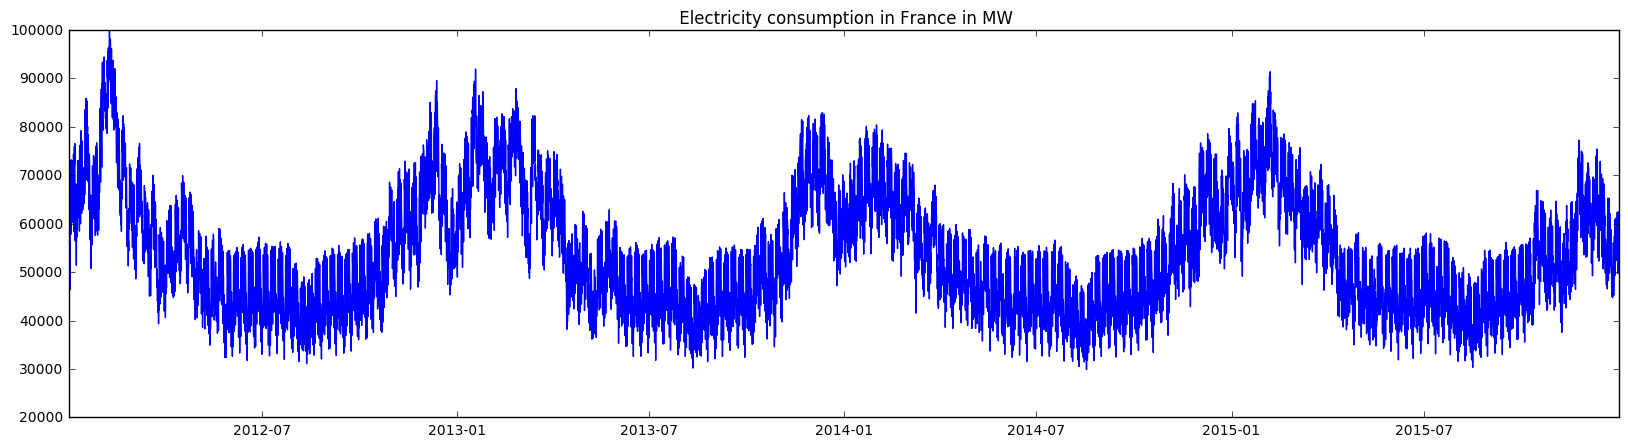

In [285]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(ts[::10].index, ts[::10])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title(" Electricity consumption in France in MW")
# plt.savefig('visualization.png')

As we can see, there is too much variation in the plot, so it would be more adequate to visualize the rolling mean since it is smoother and reprensent the data very well

If we take 48 (a day) as the length of the window, we obtain the following

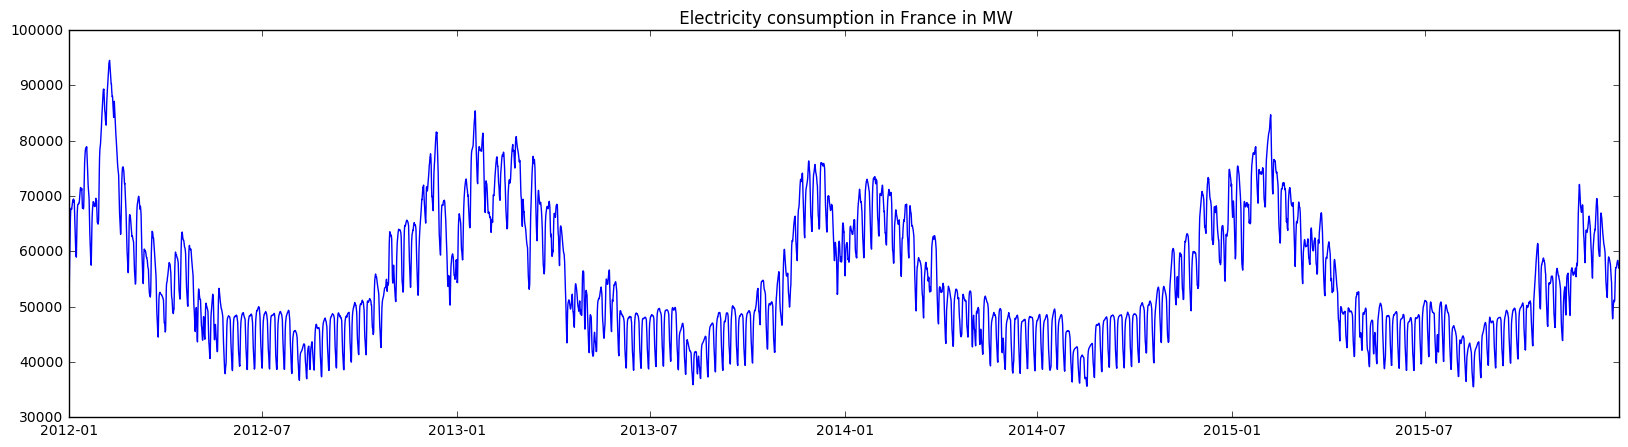

In [286]:
fig, ax = plt.subplots(figsize=(20,5))
rolling_mean = ts.rolling(center=False,window=48).mean()
ax.plot(rolling_mean.index, rolling_mean)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title(" Electricity consumption in France in MW")

The figure still has a lot of variations, therefore, we try with a larger window, say 1 week (7*48)

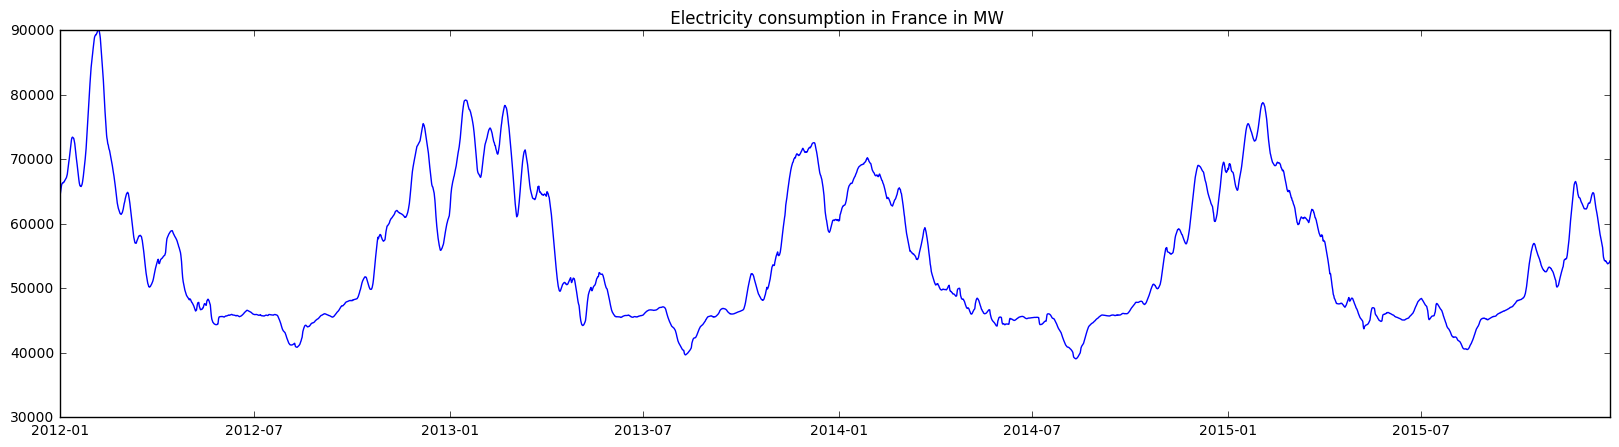

In [287]:
fig, ax = plt.subplots(figsize=(20,5))
rolling_mean = ts.rolling(center=False,window=48*7).mean()
ax.plot(rolling_mean.index, rolling_mean)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title(" Electricity consumption in France in MW")

and 1 month

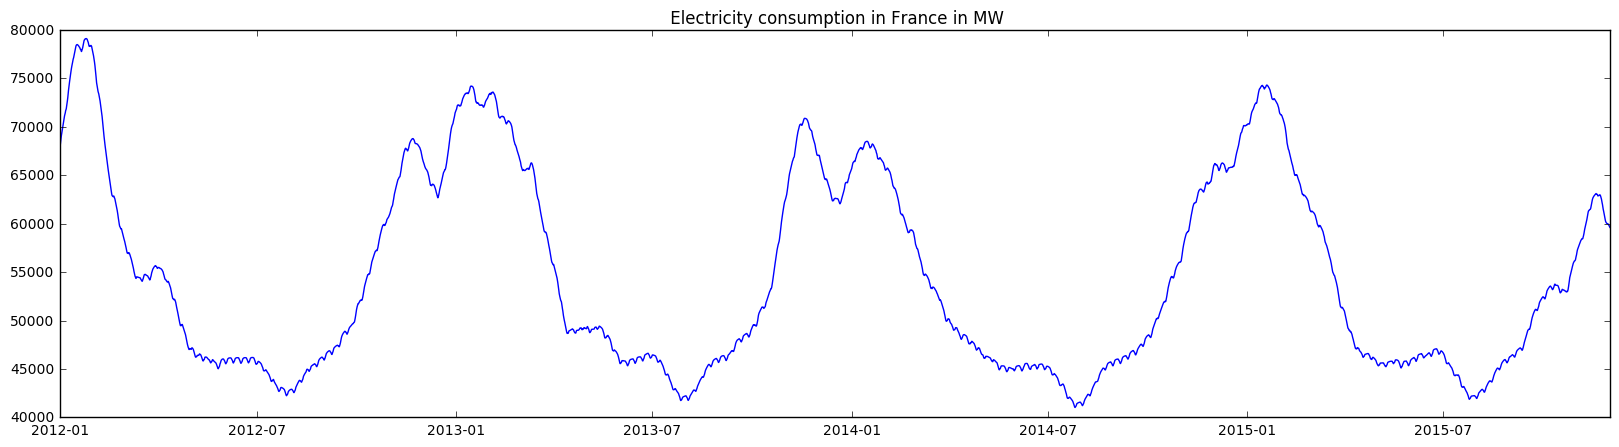

In [288]:
fig, ax = plt.subplots(figsize=(20,5))
rolling_mean = ts.rolling(center=False,window=48*30).mean()
ax.plot(rolling_mean.index, rolling_mean)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_title(" Electricity consumption in France in MW")

# Stationarization

## Getting the period

With a 1-month window, we get a smooth curve, which allows us to find the periodicity of our time series. ARMA models are not fit to modelize periodic time series, so we have to do some preprocessing by eliminating the periodicity in the data. Let's find the frequency of our data.

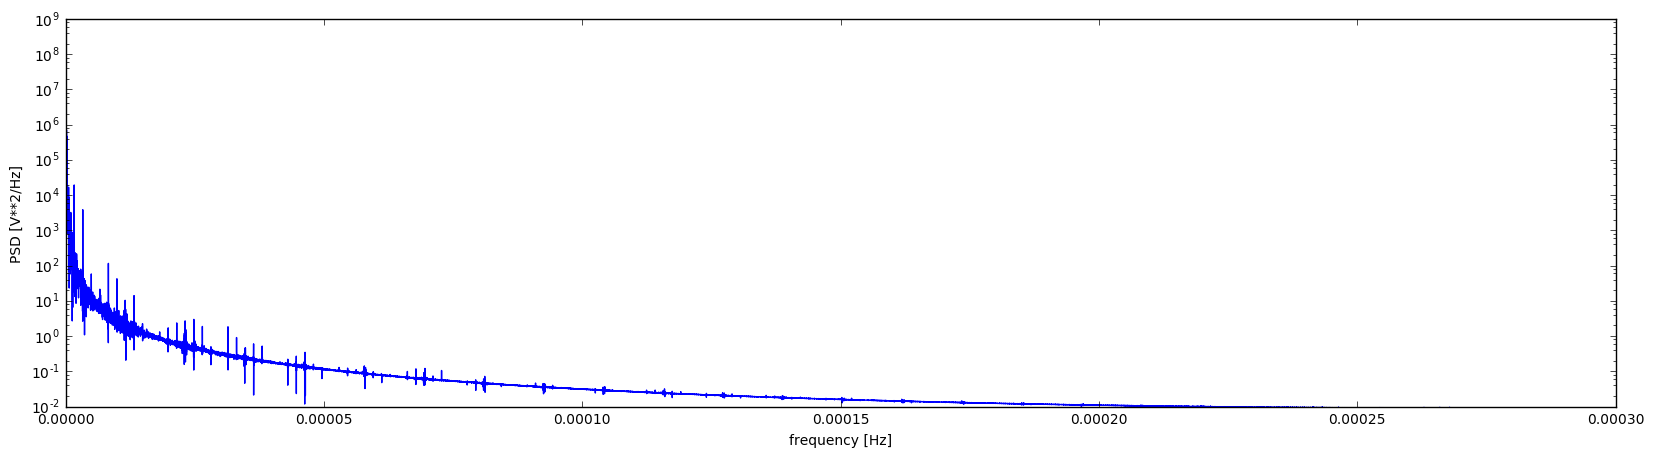

In [289]:
rolling_mean = rolling_mean.dropna()
fig, ax = plt.subplots(figsize=(20,5))
f, PSD = signal.periodogram((rolling_mean.values-np.mean(rolling_mean.values))/np.std(rolling_mean.values), fs = 1/(30*60))
ax.semilogy(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([1e-2, 1e9])
plt.show()

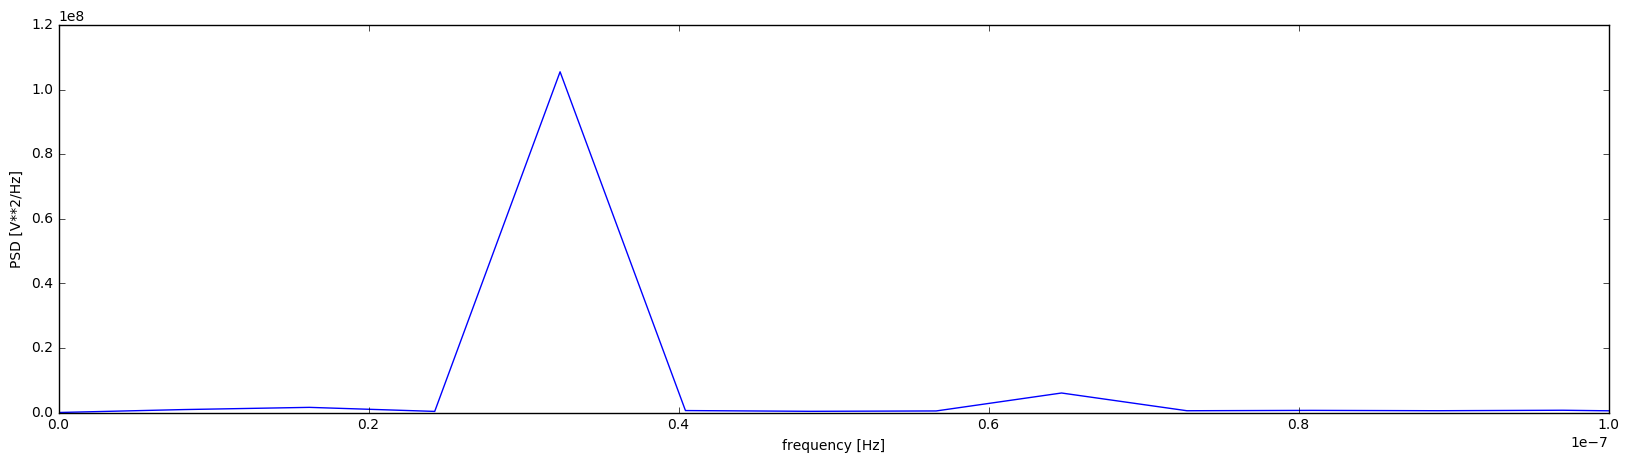

3.23519373149e-08
1.02094949701
17172.25


In [290]:
fig, ax = plt.subplots(figsize=(20,5))
f, PSD = signal.periodogram((rolling_mean.values-np.mean(rolling_mean.values))/np.std(rolling_mean.values), fs = 1/(30*60))
ax.plot(f, PSD)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim([0, 0.0000001])
plt.show()
freq_Hz = f[PSD.argmax(axis=0)];
print(freq_Hz)
print(freq_Hz*60*60*24*365.25)
print(1/(freq_Hz*60*30))

In [291]:
rolling_mean.values.shape

(68689,)

The PSD ( Power Spectral Density) seems be able to detect the frequency, which is equal to $3.23 * 10^{-8}$. in terms of number of points the period is equal to $\texttt{period} = \frac{1}{3.23*10^{-8}*60*30} = 17172$.Manually,  We can see that in our range, there is approximatively 4 periods, so the period would be the range divided by 4 i.e $\texttt{period} = \frac{70000}{4} = 17500, it turns out to be a good approximation.$

## Seasonal decomposition

We can try to decompose our data in trend, seasonality and residuals. Let's split them into train and test

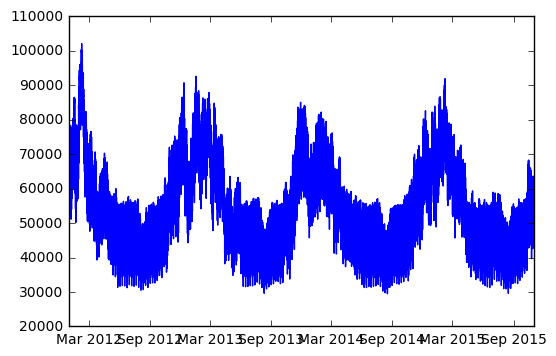

In [292]:
ts_train = data_final[data_final['Date'] <= '2015-10-31']
ts_train = pd.Series(ts_train['Consommation'].values, index = ts_train['timestamp'].values )
plt.plot(ts_train)

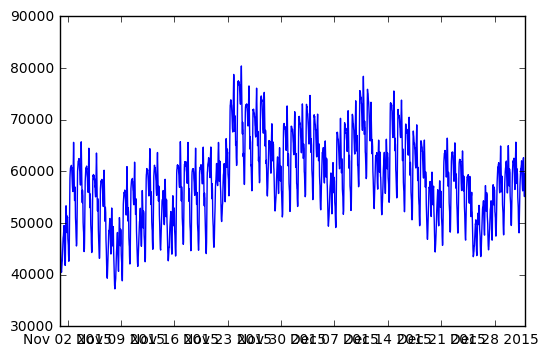

In [293]:
ts_test = data_final[data_final['Date'] > '2015-10-31']
ts_test=pd.Series(ts_test['Consommation'].values, index = ts_test['timestamp'].values )
plt.plot(ts_test)

We then perform the decomposition

54655.856447632519

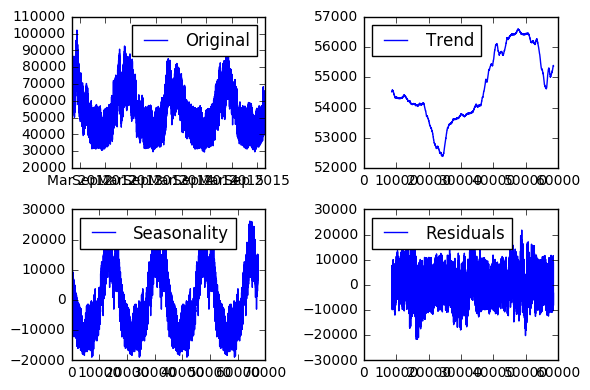

In [294]:
seasonal_dec = seasonal_decompose(ts_train.values, freq = 17172)

data_trend = seasonal_dec.trend
data_seasonal = seasonal_dec.seasonal
data_residual = seasonal_dec.resid

plt.subplot(221)
plt.plot(ts_train, label='Original')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(data_trend, label='Trend')
plt.legend(loc='best')
plt.subplot(223)
plt.plot(data_seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(224)
plt.plot(data_residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
np.mean(seasonal_dec.trend[np.logical_not(np.isnan(seasonal_dec.trend))])

As we can see, we obtain residuals with a 15000 amplitude (20% of the mean value of the series), and a 25000 amplitude seasonality. The trend is nearly constant (= 55000). The principal part would be the prediction of the residuals, which have the form of a white noise. We could generate a white noise with the same characteristics (variance), but applying ARIMA to forecast these residuals can give good results.

We can use a statistic test named Dickey-Fuller to be more sure of the stationarity of the data. We hence define a function that test the stationarity of the time series.

In [295]:
def test_stationarity(ts, stationarity):

    orig = plt.plot(ts, color='blue',label='Original')
    
    rolling_mean = ts.rolling(center=False,window=stationarity).mean()
    rolling_std = ts.rolling(center=False,window=stationarity).std()
    
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

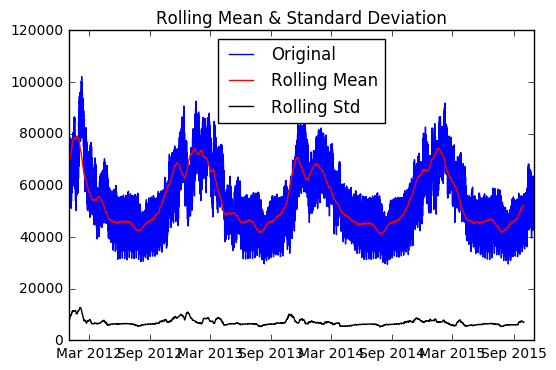

Results of Dickey-Fuller Test:
Test Statistic                -7.956634e+00
p-value                        3.025025e-12
#Lags Used                     6.200000e+01
Number of Observations Used    6.713700e+04
Critical Value (10%)          -2.566793e+00
Critical Value (5%)           -2.861583e+00
Critical Value (1%)           -3.430447e+00
dtype: float64


In [296]:
test_stationarity(ts_train, 48*30)

The results of the Dickey-Fuller test confirm the observation that the data are stationnary (since the test statistic $-7.95$ is less than the critical value (1%) $-3.43$), we can try to differentiate to see the effect that could have on the stationarity.

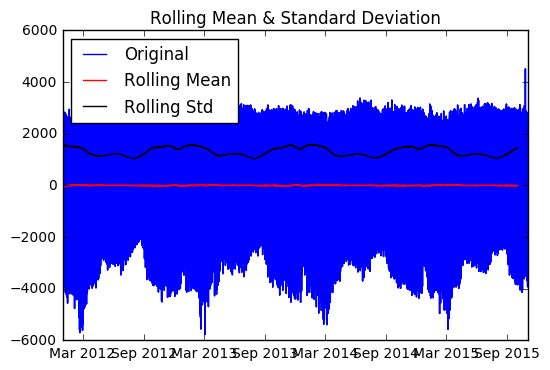

Results of Dickey-Fuller Test:
Test Statistic                   -32.912833
p-value                            0.000000
#Lags Used                        62.000000
Number of Observations Used    67136.000000
Critical Value (10%)              -2.566793
Critical Value (5%)               -2.861583
Critical Value (1%)               -3.430447
dtype: float64


In [297]:
ts_train_diff = ts_train - ts_train.shift()
plt.plot(ts_train_diff)
ts_train_diff.dropna(inplace=True)
test_stationarity(ts_train_diff, 48*30)

By differencing our data once, we get more stationarity (Test Statistic $-32 \leq -8$ that we had before).

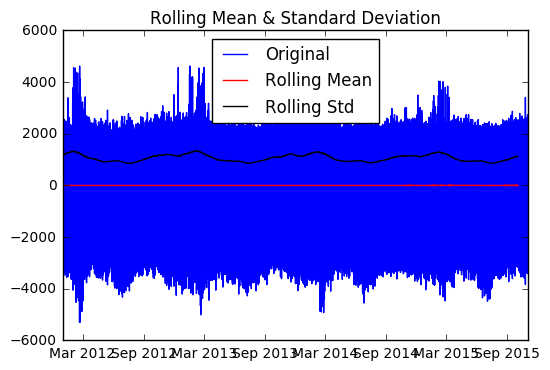

Results of Dickey-Fuller Test:
Test Statistic                   -59.581937
p-value                            0.000000
#Lags Used                        62.000000
Number of Observations Used    67135.000000
Critical Value (10%)              -2.566793
Critical Value (5%)               -2.861583
Critical Value (1%)               -3.430447
dtype: float64


In [298]:
ts_train_diff2 = ts_train_diff - ts_train_diff.shift()
ts_train_diff2.dropna(inplace=True)
test_stationarity(ts_train_diff2, 48*30)

We notice that, the more we differenciate the data, the better is the stationarity.

But since the data provided are already stationary, we don't need the integrated part of the ARIMA, we will then fix the d value (degree of differentiation) to 0.

# Autocorrelation and Partial Autocorrelation

We focus now on finding the parameters of the ARMA model.

In [302]:
data_residual = data_residual[np.logical_not(np.isnan(data_residual))]
mn =np.mean(data_residual)
stdd = np.std(data_residual)
print(mn)
print(stdd)

185.888727454
5960.50100603


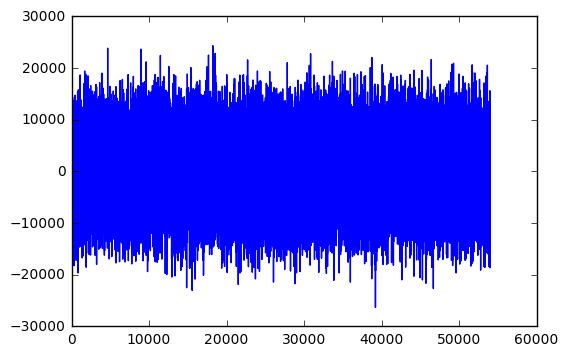

In [303]:
samples = np.random.normal(mn, stdd, size= 54000)
plt.plot(samples)

We try to approximate the first degree difference with an ARMA model. We find the parameters of the AR and MA through the autocorrelation and partial autocorrelation functions.

In [304]:
acf_lag = acf(ts_train_diff, nlags=20)
pacf_lag = pacf(ts_train_diff, nlags=20, method='ols')

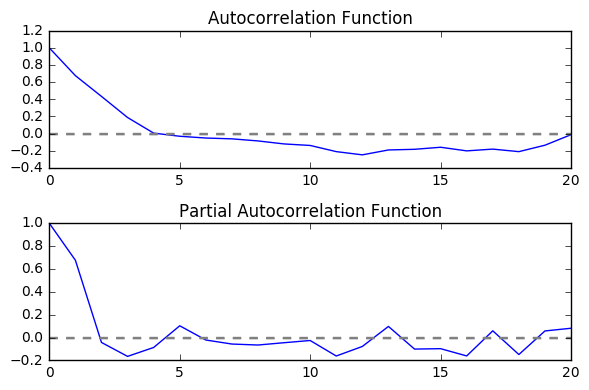

In [305]:
plt.subplot(211) 
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_train_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(212)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_train_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#plt.savefig('auto_partial.png')

The degree of the MA part appears to be equal to 4, because it is the threshold where the autocorrelation function starts to be negative.

The degree of the MA part is equal to 2 (the same argument as before with the partial autocorrelation function instead of the autocorrelation function).

# Building the model

## AR Model

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -30T will be used.
  % freq, ValueWarning)


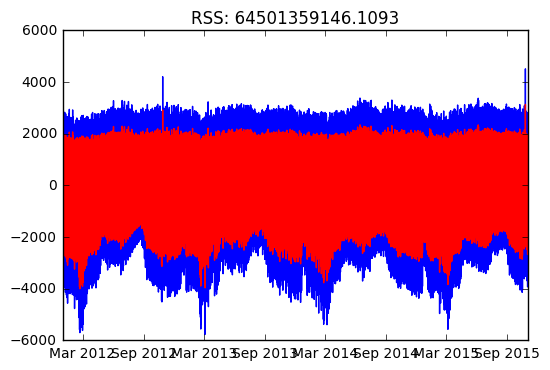

In [306]:
model = ARIMA(ts_train, order=(2, 1, 0))  
AR_results = model.fit(disp=-1)  
plt.plot(ts_train_diff)
plt.plot(AR_results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((AR_results.fittedvalues-ts_train_diff)**2))

## MA Model

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -30T will be used.
  % freq, ValueWarning)


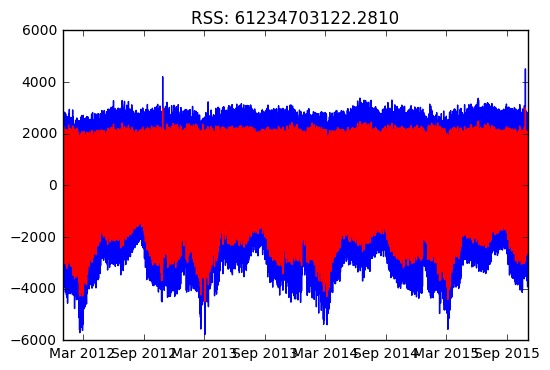

In [307]:
model = ARIMA(ts_train, order=(0, 1, 4))  
MA_results = model.fit(disp=-1)  
plt.plot(ts_train_diff)
plt.plot(MA_results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((MA_results.fittedvalues-ts_train_diff)**2))

## ARMA model

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -30T will be used.
  % freq, ValueWarning)


879913.6204776417

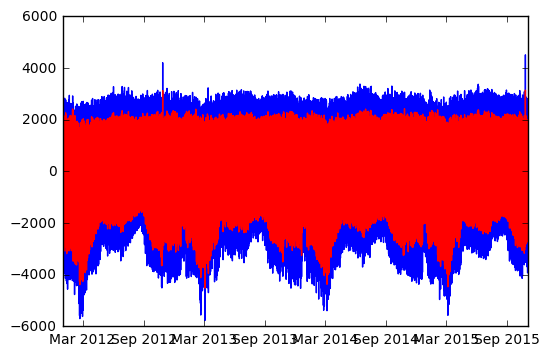

In [308]:
model = ARIMA(ts_train, order=(2, 1, 4))  
ARIMA_results = model.fit(disp=-1)  
plt.plot(ts_train_diff)
plt.plot(ARIMA_results.fittedvalues, color='red')
sum(((ARIMA_results.fittedvalues-ts_train_diff))**2)/len(ts_train_diff)
#plt.savefig('ARMA.png')

We notice that the fitted values have the same form but not the good amplitude, so we multiply by a factor in order to fit with the max and min.

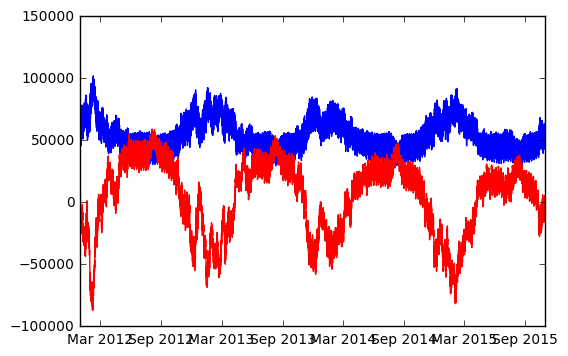

In [309]:
plt.plot(ts_train)
plt.plot(np.cumsum(results_ARIMA.fittedvalues), color='red')
#plt.savefig('cumsum.png')

973504.48973417887

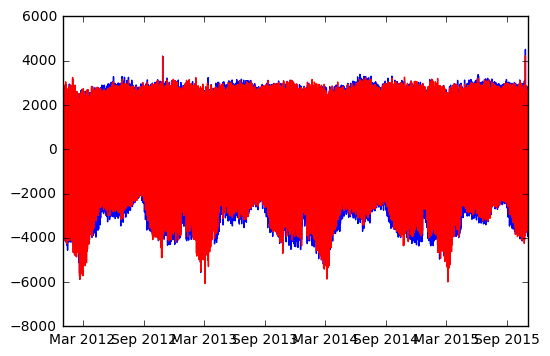

In [310]:
res = results_ARIMA.fittedvalues
res = res * (np.max(ts_train_diff)-np.min(ts_train_diff))/(np.max(res)-np.min(res))
plt.plot(ts_train_diff)
plt.plot(res, color='red')
sum(((res-ts_train_diff))**2)/len(ts_train_diff)

But we notice that we increased the error by doing so.

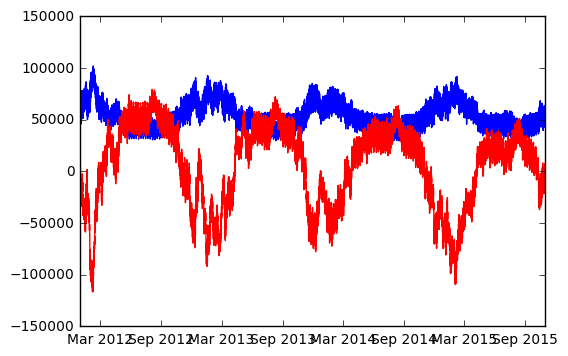

In [311]:
plt.plot(ts_train)
plt.plot(np.cumsum(res), color='red')

We can see that we get sort of the opposite of what we should obtain (modulo normalization), we can calculate the error if we fix the problem

0.13559740194242034

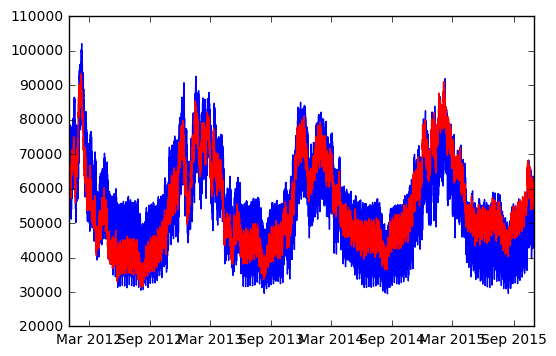

In [312]:
plt.plot(ts_train)
res1 = -np.cumsum(res)
res2 = (res1 - np.mean(res1))*np.std(ts_train)/np.std(res1)+np.mean(ts_train)
plt.plot(res2, color='red')
#plt.savefig('modified.png')

MSE = sum(np.abs((res2 - ts_train.values[:-1]))/res2)/len(res2)
MSE


We get a training error of 13%. Let's apply the predictions on the validation set.

We will train our model and use it to predict one value after, for 15 times (the first 15 values of the test set)

Firstly, we alimen the dynamic set with the observations in order to prediction the next ones

In [314]:
dynamic_train_set = [x for x in ts_train]
predictions = list()
nb_tests = 15
for t in range(nb_tests):
    model = ARIMA(dynamic_train_set, order=(2,1,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = ts_test[t]
    dynamic_train_set.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=58624.374866, expected=59512.000000
predicted=60061.882399, expected=59518.000000
predicted=59265.734922, expected=56150.000000
predicted=54086.113213, expected=55140.000000
predicted=54124.355292, expected=55762.000000
predicted=56659.959237, expected=56787.000000
predicted=58380.177099, expected=58337.000000
predicted=59283.635245, expected=60030.000000
predicted=60794.168955, expected=61696.000000
predicted=62760.510906, expected=62660.000000
predicted=63296.097332, expected=62485.000000
predicted=62082.782790, expected=62111.000000
predicted=61494.244782, expected=59809.000000
predicted=58263.330539, expected=57001.000000
predicted=55146.314246, expected=56242.000000


In [315]:
RMSE = np.sqrt(sum(((predictions-ts_test.values[:nb_tests-1])/predictions)**2)[0]/nb_tests)
RMSE

0.051254706217329422

In [317]:
dynamic_train_set = [x for x in ts_train]
predictions = list()
nb_tests = 15
for t in range(nb_tests):
    model = ARIMA(dynamic_train_set, order=(2,1,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = ts_test[t]
    dynamic_train_set.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=58624.374866, expected=59512.000000
predicted=58588.353180, expected=59518.000000
predicted=58232.952486, expected=56150.000000
predicted=58286.084566, expected=55140.000000
predicted=58423.162494, expected=55762.000000
predicted=58568.443788, expected=56787.000000
predicted=58705.036522, expected=58337.000000
predicted=58829.935699, expected=60030.000000
predicted=58943.343007, expected=61696.000000
predicted=59046.130007, expected=62660.000000
predicted=59139.239762, expected=62485.000000
predicted=59223.585889, expected=62111.000000
predicted=59299.985754, expected=59809.000000
predicted=59369.174004, expected=57001.000000
predicted=59431.837287, expected=56242.000000


In [318]:
RMSE = np.sqrt(sum(((predictions-ts_test.values[:nb_tests-1])/predictions)**2)[0]/nb_tests)
RMSE

0.013094539986271489

We got a good score (5%) for 1 30-minute forecasting, and 1% if we retrain the model dynamically. But 30-minutes prediction is not enough, we will have to try with more lag prediction.

In [319]:
history = [x for x in ts_train]
model = ARIMA(history, order=(2,1,4))
model_fit = model.fit(disp=0)

In [320]:
tests = list()
for nb_test in range(test_len[0]):
    output = model_fit.forecast(nb_test+1)
    predictions = output[0]
    tests.append(np.sqrt((sum(np.abs(((predictions-ts_test[:nb_test+1]))/predictions)**2))/(nb_test+1)))

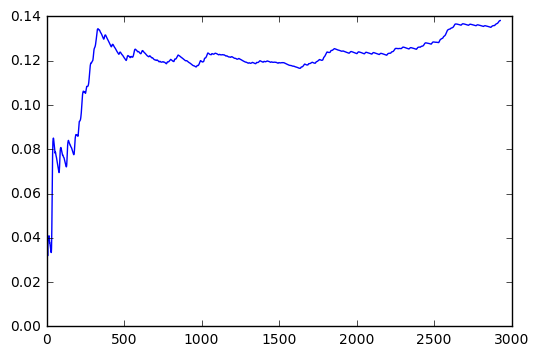

In [321]:
plt.plot(tests)

In [322]:
tests[:47]

[0.015140888679079714,
 0.012511782682397294,
 0.026264187988647415,
 0.031350188658031526,
 0.036739835042330082,
 0.035763937406773368,
 0.033195705864975319,
 0.031878112004099977,
 0.033846731273564599,
 0.037491499239742099,
 0.039607818630101092,
 0.04044896729494598,
 0.038934945117569161,
 0.039003927806757696,
 0.040148961468498522,
 0.040864307514350245,
 0.040966033338251856,
 0.040532466964516463,
 0.039501289324051773,
 0.038501100847965222,
 0.037752140526063502,
 0.037799897773285997,
 0.037401062804980859,
 0.036927744422846645,
 0.036334164426015461,
 0.035705232440117328,
 0.035110887774869329,
 0.034503554545380608,
 0.033908186756295478,
 0.033517307476941149,
 0.033382804924796006,
 0.03371759783255919,
 0.035334293885900495,
 0.038907282793968261,
 0.043953793605905733,
 0.051235823268284603,
 0.058588003504453354,
 0.066106066080419384,
 0.072444670526140661,
 0.077595263021902172,
 0.081161910052332809,
 0.083459597633668989,
 0.084351084783231167,
 0.0849055225

We get a good score for the first iterations, and asymptotically, we have a 12% error. In fact, if we plot the predictions, we will be convinced of the problem

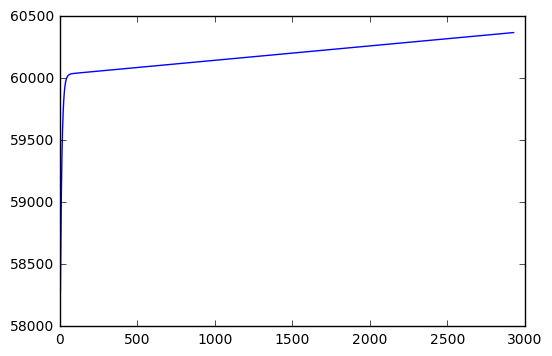

In [323]:
plt.plot(predictions)

The ARIMA model is not fit to predict our data model. Before we try another approach let's change the parameters a little bit to see the impact on the predictions

In [324]:
history = [x for x in ts_train]
model = ARIMA(history, order=(2,1,9))
model_fit = model.fit(disp=0)

In [325]:
tests = list()
for nb_test in range(test_len[0]):
    output = model_fit.forecast(nb_test+1)
    predictions = output[0]
    tests.append(np.sqrt((sum(np.abs(((predictions-ts_test[:nb_test+1]))/predictions)**2))/(nb_test+1)))

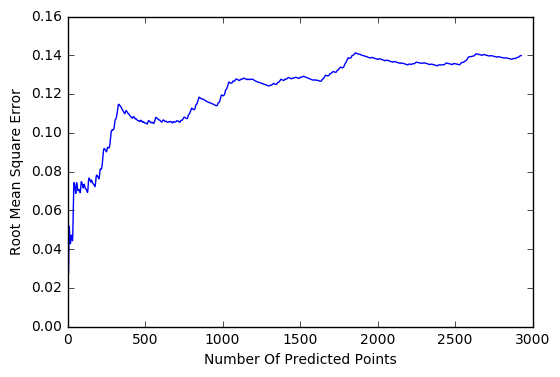

In [326]:
plt.plot(tests)
plt.ylabel('Root Mean Square Error')
plt.xlabel('Number Of Predicted Points')
#plt.savefig('error.png')

In [327]:
history = [x for x in ts_train]
model = ARIMA(history, order=(2,1,9))
model_fit = model.fit(disp=0)

In [328]:
tests = list()
for nb_test in range(test_len[0]):
    output = model_fit.forecast(nb_test+1)
    predictions = output[0]
    tests.append(np.sqrt((sum(np.abs(((predictions-ts_test[:nb_test+1]))/predictions)**2))/(nb_test+1)))

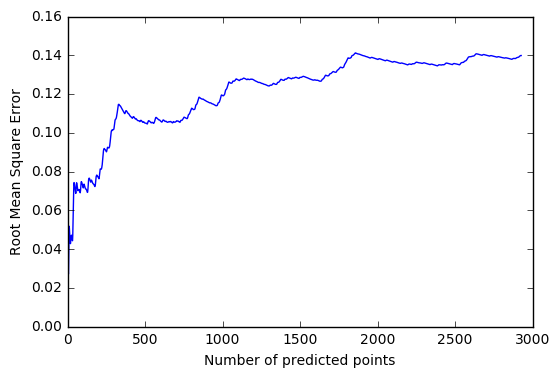

In [329]:
plt.plot(tests)
plt.ylabel('Root Mean Square Error')
plt.xlabel('Number of predicted points')

The result is still not satisfying. We will use another approach.

# SARIMAX Approach

Since the fitted values don't even stick with the training set, the ARIMA approach wasn't convenient in this case (periodic time series). Hence, we will apply the same operations but using an adapted form of ARIMA that is fitted to the periodic case. This form of ARIMA is called SARIMA (for Seasonal ARIMA).

In [330]:
train_len = ts_train.shape
print('size of training data : {}'.format(train_len[0]))
test_len = ts_test.shape
print('size of test data : {}'.format(test_len[0]))

size of training data : 67200
size of test data : 2928


We perform the same operations as before to determine the parameters.

In [331]:
ts_train_diff = ts_train - ts_train.shift(12)
ts_train_diff = ts_train_diff.dropna(inplace=False)

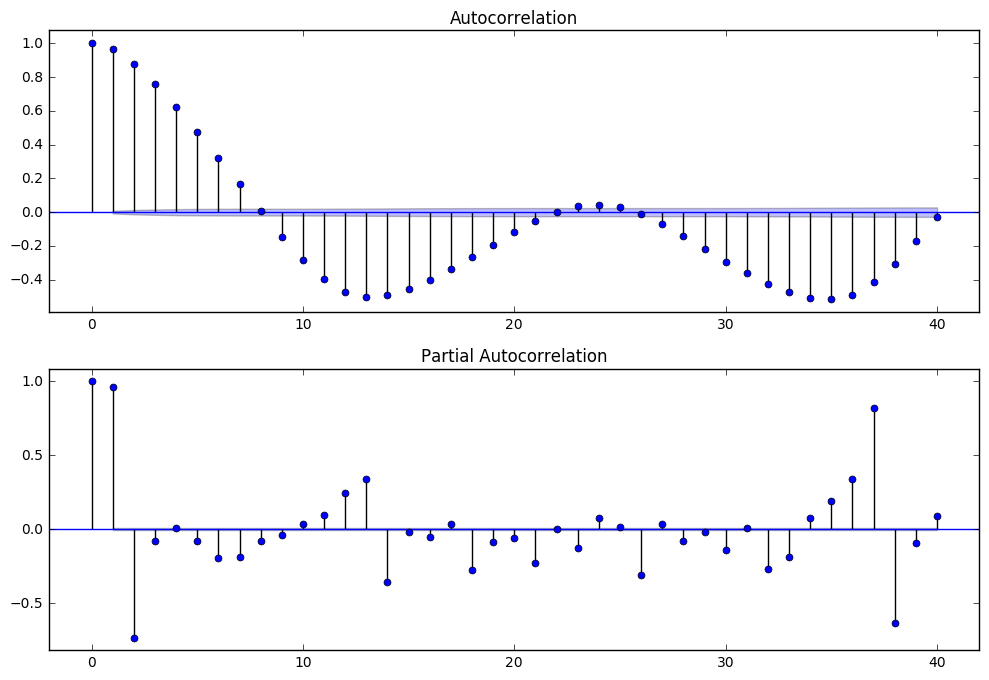

In [332]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = smapi.graphics.tsa.plot_acf(ts_train_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = smapi.graphics.tsa.plot_pacf(ts_train_diff.iloc[13:], lags=40, ax=ax2)

We conclude that the p parameter for the Auto Regressive part is equal to 3, and the q parameter for the Moving Average part is equal to 9.

Now we will train our model

In [333]:
mod = sm.tsa.statespace.sarimax.SARIMAX(ts_train, trend='c', order=(2,1,4), seasonal_order=(1,1,1,1))
# c because our trend is nearly constant
# order determined by the autocorrelation and partial autocorrelation function
# s = 1 because we have a 1 year seasonality
results = mod.fit()
print(results.summary())

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency -30T will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                67200
Model:             SARIMAX(2, 1, 4)x(1, 1, 1, 1)   Log Likelihood             -556621.673
Date:                           Tue, 31 Jan 2017   AIC                        1113263.346
Time:                                   23:36:00   BIC                        1113354.501
Sample:                               10-31-2015   HQIC                       1113291.513
                                    - 01-01-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.71e-05      0.001      0.035      0.972      -0.003       0.003
ar.L1          0.1763      0.425      0.415

C:\Users\Lenovo\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1725: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


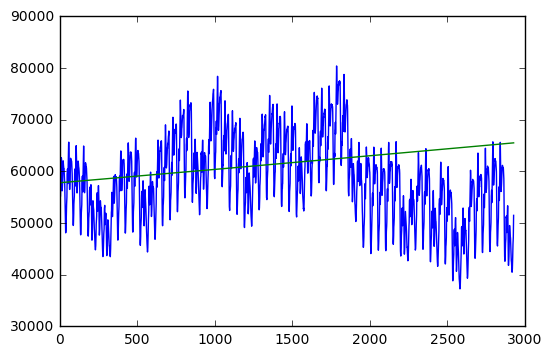

In [334]:
res3 = results.predict(start = train_len[0]+1, end= train_len[0]+test_len[0], dynamic= True)  
plt.figure()
plt.plot(ts_test.values)
plt.plot(res3.values)